## Beer Recommendation System 

Fall 2018, 4571 Recommendation System and Personalization 

Homework 2

In [1]:
# python2
import pandas as pd
import numpy as np
import os
import itertools as it
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter

In [2]:
os.getcwd()
os.chdir('/Users/yilinsun/Desktop/4571/project/')

## Preprocess Metadata

In [3]:
# Convert .txt to .csv file
file = open('beeradvocate.txt')
file2 = open("beeradvocate_fullset.csv", "w")

for i in file:
    #count = count + 1 
    line = ""
    while i != '\n':
        line = line + i.split(":", 1)[1].rstrip()
        if(not("review/text" in i)):
            line = line +  "^" 
        i = file.next()
    file2.write(line + "\n")

file.close()

In [4]:
#### Read .csv into python
data = pd.read_csv('beeradvocate_fullset.csv', sep="^" , engine='python', 
                   header=None, error_bad_lines=False, warn_bad_lines=False)

data.columns = ['beer_name', 'beer_beerId', 'beer_brewer', 'beer_ABV', 'beer_style', 
                'review_appearance', 'review_aroma', 'review_palate', 'review_taste', 'review_overall', 
                'review_time', 'review_profileName', 'review_text']

print('Metadata size: %s' % str(data.shape))

Metadata size: (1586040, 13)


## Part 1:  Neighborhood-based Collabrotive Filtering

- two types: item-based, user-based
- distances: use Pearson similiarity for now (could use cosine,  Euclidean, adjusted-cosine too)
- tune param: neighborhood_size k

### Define functions

In [5]:
# Define function: convert input dataframe to rating matrix
# matrix shape = num_user * num_item
def Rmat(users_dict, beers_dict, trainset):
    rmat = np.full([m, n], np.nan)
    for i in range(trainset.shape[0]):
        row, col = users_dict.get(trainset.review_profileName[i]), beers_dict.get(trainset.beer_name[i])
        rmat[row][col] = trainset.review_overall[i]
    return rmat

In [6]:
# Define function: Pearson distance
# pairwise correlation between users/items
def Pearson(u, v):
    common_ind = pd.notnull(u) & pd.notnull(v)
    if sum(common_ind) == 0:
        return None
    else:
        u2, v2 = u[common_ind], v[common_ind]
        sim = sum(u2*v2)/((sum(u2**2)**(.5))*(sum(v2**2)**(.5)))
        return np.round(sim, 5)

In [7]:
# Define function: Predict rating
def PredRating(sim_mat, adj_rmat, i, j, k_neighbor, user_or_item):
    
    # find mu, similiarity_vector, adj_rating vector
    if user_or_item == 'user':
        mu = np.nanmean(train_rmat[i]) 
        ind1 = pd.notnull(adj_rmat[:,j])
        adj_r_vec = adj_rmat[:,j][ind1]
        sim_vec = sim_mat[i][ind1] 
    elif user_or_item == 'item':
        mu = np.nanmean(train_rmat[:,j])
        ind1 = pd.notnull(adj_rmat[i])
        adj_r_vec = adj_rmat[i][ind1]
        sim_vec = sim_mat[j][ind1]
    else:
        return 'wrong input: user or item'
    
    if sum(pd.isnull(sim_vec))>0:
        ind = pd.notnull(sim_vec)
        if len(ind) == 0:
            return None
        sim_vec, adj_r_vec = sim_vec[ind], adj_r_vec[ind]
    
    # take k nearest neighbor 
    if len(sim_vec) > k_neighbor:
        ind2 = np.argsort(sim_vec, kind='quicksort')[-k_neighbor:]
        sim_vec, adj_r_vec = sim_vec[ind2], adj_r_vec[ind2]
     
    # final rating
    numer, demon = sim_vec*adj_r_vec, np.absolute(sim_vec)
    pred_rating = mu + sum(numer)/sum(demon)

    return np.round(pred_rating, 3)

In [8]:
# Define error metric: RMSE
def RMSE(test_mat, pred_mat):
    test_mat, pred_mat = np.ndarray.flatten(test_mat), np.ndarray.flatten(pred_mat)
    ind_rmse = pd.notnull(test_mat) & pd.notnull(pred_mat)
    test_mat, pred_mat = test_mat[ind_rmse], pred_mat[ind_rmse]
    
    error = np.mean((test_mat - pred_mat)**2)**(.5)
    
    return np.round(error, 4)

### Data Prepocessing

In [9]:
#### Subset original dataset for hw2

# Subset 4 columns: user name, beer name, overall score, review_time
data2 = data[['beer_name', 'review_profileName', 'review_overall','review_time']]
print('Original data size: %s' % str(data2.shape)) 

# Remove NA 
data2 = data2[pd.notnull(data2.beer_name)]
data2 = data2[pd.notnull(data2.review_profileName)]
data2 = data2[pd.notnull(data2.review_overall)]
print('After removing NAs: %s' % str(data2.shape)) 

# Drop duplicate (beer&user) pairs, keep the latest rating
data2['beer_user_pair'] = data2.beer_name + data2.review_profileName
data2 = data2.sort_values(by=['review_time'], ascending=False).drop_duplicates(subset=['beer_user_pair'])
print('After drop duplicate user-item pairs (only keep the latest score), data size: %s' % str(data2.shape)) 

Original data size: (1586040, 4)
After removing NAs: (1585692, 4)
After drop duplicate user-item pairs (only keep the latest score), data size: (1560849, 5)


In [10]:
# Take m users & n items
m, n = 1000, 100

# Take top 1000/33382 most frequent users
user_freqtable = data2.review_profileName.value_counts()
user_list = user_freqtable.keys()[:m].tolist()

# Take top 100/56855 most reviewed beer
beer_freqtable = data2.beer_name.value_counts()[:200]
beer_list = beer_freqtable.keys()[:n].tolist()

# Final sample size
subdata = data2[data2.beer_name.isin(beer_list)]
subdata = subdata[subdata.review_profileName.isin(user_list)]
print('Take the top %d users and top %d items as sample data. The Sample size is %s.' % (m,n,str(subdata.shape))) 

Take the top 1000 users and top 100 items as sample data. The Sample size is (62244, 5).


In [11]:
# Split training & test set: should not have empty rows or columns
subdata2 = subdata[['beer_name','review_profileName','review_overall']]

train, test = train_test_split(subdata2, test_size=.2, random_state=1)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Create index dict; keys are user/beer names, values are corresponding row/col in rmat
user_dict = {user_list[k]: k for k in range(m)}
beer_dict = {beer_list[k]: k for k in range(n)}

# Create train rating matrix: for both used- and item-based
train_rmat = Rmat(user_dict, beer_dict, train)

# Create test rating matrix: for both used- and item-based
test_rmat = Rmat(user_dict, beer_dict, test)

# Create prediction matrix - NaN
user = np.where(pd.notnull(test_rmat))[0] 
item = np.where(pd.notnull(test_rmat))[1] 

pred_rmat_user = np.full([m, n], np.nan)
pred_rmat_item = np.full([m, n], np.nan)

In [12]:
# check if there is empty row/column in training set
0 in np.sum(train_rmat, axis=0), 0 in np.sum(train_rmat, axis=1)

(False, False)

In [13]:
print(train.head(5))

                       beer_name review_profileName  review_overall
0         Trappistes Rochefort 8             WesWes             4.5
1   Chimay Grande Réserve (Blue)           1fastz28             4.5
2    Hennepin (Farmhouse Saison)           dgallina             5.0
3                     Prima Pils        fisherman34             4.5
4         Trappistes Rochefort 8             nrbw23             4.0


In [14]:
print(test.head(5))

                    beer_name review_profileName  review_overall
0           Palo Santo Marron     johnmichaelsen             3.5
1     Bell's Expedition Stout          OWSLEY069             4.5
2   Samuel Adams Boston Lager    treehugger02010             3.5
3          Bell's Hopslam Ale      feloniousmonk             4.0
4           Bell's Oberon Ale         prototypic             4.5


In [15]:
train_rmat[:2,] # rating of user1 and user2 for all beers

array([[4.5, 4. , 4.5, 4. , nan, 4.5, 3.5, 4. , 4. , 4. , 4. , 4.5, 4. ,
        nan, 4.5, 4.5, 3.5, 4. , 4.5, nan, 3.5, 4. , 5. , 4. , nan, 4.5,
        3.5, 3.5, 4.5, 2. , nan, 5. , 4.5, 4. , 4.5, 4.5, nan, 4.5, nan,
        4. , 4. , nan, 4. , nan, nan, 3.5, 3.5, 4.5, 3.5, nan, 3. , 4. ,
        4. , 3.5, 3.5, nan, 4.5, 4. , 3.5, 4.5, 3. , nan, nan, 4. , 4.5,
        4. , 4. , 3.5, 3.5, 3. , 4. , 3.5, 4. , 4.5, nan, 4.5, 3.5, 4. ,
        3.5, 3. , 4. , 4. , 4. , 4.5, nan, 3. , 3. , nan, nan, 4. , 1. ,
        nan, 4. , 4.5, nan, 4. , 3.5, 4. , nan, 4. ],
       [4. , nan, 4.5, 4.5, 4. , nan, 4.5, 4.5, 4. , 5. , 4. , 5. , 5. ,
        4. , nan, 4.5, 4.5, 5. , nan, 4.5, 4. , 5. , 4.5, 4.5, 4. , 5. ,
        nan, 4. , nan, 2. , 4.5, 4.5, 2. , 3. , 4.5, 4.5, 5. , 3.5, 3.5,
        3.5, 5. , 4. , 4.5, 4. , 4.5, 4. , 4.5, nan, 4.5, 5. , 4.5, nan,
        5. , 5. , 4. , 5. , 5. , 4.5, 3.5, nan, 4. , 4.5, 3.5, nan, 4.5,
        4. , 4.5, nan, nan, 3.5, 4. , 3.5, 5. , 4. , nan, 4. , 5. , 5.

### 1.  User-based Collaborative Filtering

In [16]:
# compute mean_adjusted rating of each user: subtract mean from ratings
adj_rmat_user = [train_rmat[0] - np.nanmean(train_rmat[0])]
for i in range(1,len(train_rmat)):
    adj_rmat_user = np.append(adj_rmat_user, [train_rmat[i] - np.nanmean(train_rmat[i])], axis=0)

In [17]:
# compute Pearson similiarity matrix 
sim_user = np.full([m, m], np.nan)

for u,v in it.combinations(range(len(user_list)), 2): 
    sim_user[u][v] = Pearson(adj_rmat_user[u], adj_rmat_user[v])
    sim_user[v][u] = sim_user[u][v]

/Users/yilinsun/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [18]:
# predict
k = 500
for ind in range(len(user)): 
    i, j = user[ind], item[ind]
    pred_rmat_user[i, j] = PredRating(sim_user, adj_rmat_user, i, j, k, 'user')

In [19]:
# calculate MSE
user_rmse = RMSE(test_rmat, pred_rmat_user)
print('User-based collaborative filtering error is %.4f' % (user_rmse))

User-based collaborative filtering error is 0.5319


### 2.  Item-based Collaborative Filtering

In [20]:
# compute mean_adjusted rating vector of each item
adj_rmat_item = [train_rmat[:,0] - np.nanmean(train_rmat[:,0])]
for i in range(1,len(train_rmat[0])):
    adj_rmat_item = np.append(adj_rmat_item, [train_rmat[:,i] - np.nanmean(train_rmat[:,i])], axis=0)

adj_rmat_item = np.transpose(adj_rmat_item)

In [21]:
# compuete Pearson similiarity matrix 
sim_item = np.full([n, n], np.nan)
for u,v in it.combinations(range(len(beer_list)), 2): 
    sim_item[u][v] = Pearson(adj_rmat_item[u], adj_rmat_item[v])
    sim_item[v][u] = sim_item[u][v]

In [22]:
# predict 
k = 50
for ind in range(len(item)): 
    i, j = user[ind], item[ind]
    pred_rmat_item[i, j] = PredRating(sim_item, adj_rmat_item, i, j, k, 'item')

In [23]:
# calculate MSE
item_rmse = RMSE(test_rmat, pred_rmat_item)
print('Item-based collaborative filtering error is %.4f' % (item_rmse))

Item-based collaborative filtering error is 0.5487


### 3.  Tuning Parameter  - Neighborhood Size *k*

- 3.1 user-based 
- 3.2 item-based 



- `Other parameters`: sample size *user* $*$ *item* = *1000 $*$ 100*; error metric = *RMSE*


- `Result`: the optimal neighborhood size for user-based `k=300`; item-based `k=30`

In [24]:
# define function: get mu, similiarity_vector, adj_rating vector
def get_sim_adjr(sim_mat, adj_rmat, i, j, user_or_item):
    
    # find mu, similiarity_vector, adj_rating vector
    if user_or_item == 'user':
        mu = np.nanmean(train_rmat[i]) 
        ind1 = pd.notnull(adj_rmat[:,j])
        adj_r_vec = adj_rmat[:,j][ind1]
        sim_vec = sim_mat[i][ind1] 
    elif user_or_item == 'item':
        mu = np.nanmean(train_rmat[:,j])
        ind1 = pd.notnull(adj_rmat[i])
        adj_r_vec = adj_rmat[i][ind1]
        sim_vec = sim_mat[j][ind1]
    else:
        return 'wrong input: user or item'
    
    if sum(pd.isnull(sim_vec))>0:
        ind = pd.notnull(sim_vec)
        if len(ind) == 0:
            return None
        sim_vec, adj_r_vec = sim_vec[ind], adj_r_vec[ind]
    
    return [sim_vec, adj_r_vec, mu]

In [25]:
# define function: predict ratings based on similiarity & neighborhood size k
def get_pred(sim_vec, adj_r_vec, mu, k):
    # get k neighbors
    if len(sim_vec) > k:
        ind2 = np.argsort(sim_vec, kind='quicksort')[-k:]
        sim_vec, adj_r_vec = sim_vec[ind2], adj_r_vec[ind2]
     
    # predict 
    numer, demon = sim_vec*adj_r_vec, np.absolute(sim_vec)
    pred_rating = mu + sum(numer)/sum(demon)

    return np.round(pred_rating, 5)

#### 3.1 Tuning neighborhood size *k* for User-based collaborative filtering

In [26]:
user_k = [50, 100, 200, 225, 250, 275, 300, 325, 350, 375, 400, 450, 500, 550, 600]

# create prediction matrix
pred_rmat_user_dict = {}
for k in user_k:
    pred_rmat_user_dict[str(k)] = np.full([m, n], np.nan)

# predict
for ind in range(len(item)):
    i, j = user[ind], item[ind]
    sim, adjr, mu = get_sim_adjr(sim_user, adj_rmat_user, i, j, 'user') 

    for k in user_k:
        pred_rmat_user_dict[str(k)][i, j] = get_pred(sim, adjr, mu, k)
        
# calculate error
rmse_user = []
for k in user_k:
    rmse_user.append(RMSE(test_rmat, pred_rmat_user_dict[str(k)]))

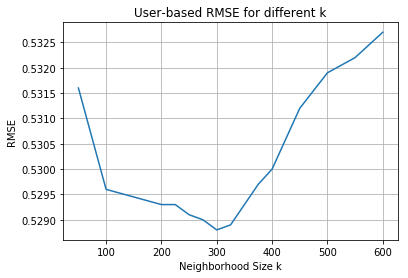

In [27]:
# Plot error
fig, ax = plt.subplots()
ax.plot(user_k, rmse_user)
ax.set(xlabel='Neighborhood Size k', ylabel='RMSE', title='User-based RMSE for different k')
ax.grid()

#### 3.2 Tuning neighborhood size *k* for Item-based collaborative filtering

In [28]:
item_k = [5, 10, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 95, 100]

# create prediction matrix
pred_rmat_item_dict = {}
for k in item_k:
    pred_rmat_item_dict[str(k)] = np.full([m, n], np.nan)

# predict
for ind in range(len(item)):
    i, j = user[ind], item[ind]
    sim, adjr, mu = get_sim_adjr(sim_item, adj_rmat_item, i, j, 'item') 

    for k in item_k:
        pred_rmat_item_dict[str(k)][i, j] = get_pred(sim, adjr, mu, k)
        
# calculate error
rmse_item = []
for k in item_k:
    rmse_item.append(RMSE(test_rmat, pred_rmat_item_dict[str(k)]))

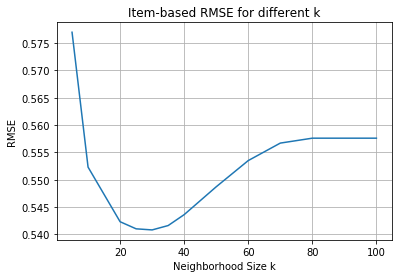

In [29]:
# Plot error
fig, ax = plt.subplots()
ax.plot(item_k, rmse_item)
ax.set(xlabel='Neighborhood Size k', ylabel='RMSE', title='Item-based RMSE for different k')
ax.grid()

### 4. Compare Three Error Metrics


- 4.1 Root Mean Square Error (RMSE) 
- 4.2 Mean Absolute Error (MAE)

`Methods`: find the optimal neighborhood size *k* using *RMSE* and *MAE* and compare


- 4.3 Ranking Based Error 

`Methods`: calculate the percentage of predicted top _t_ beers in the true top _t_ beer list for each user. (Using beers with explicit ratings. For example, if user _i_ have rated 60 beers out of 100, then the true-top-10-beer-list is the top 10 out of 60. ignore the rest 40.)

#### 4.1 Root Mean Square Error (RMSE)

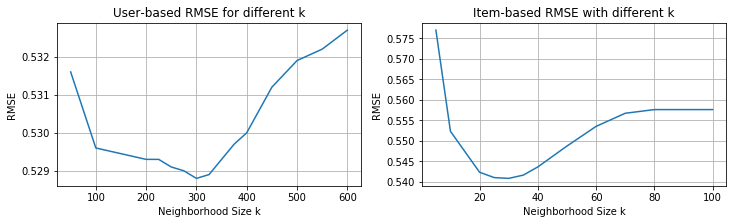

In [30]:
# Plot RMSE error, follow the previous section
fig = plt.figure(figsize=(12,3))

ax1 = fig.add_subplot(121)
ax1.plot(user_k, rmse_user)
ax1.set(xlabel='Neighborhood Size k', ylabel='RMSE', title='User-based RMSE for different k')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(item_k, rmse_item)
ax2.set(xlabel='Neighborhood Size k', ylabel='RMSE', title='Item-based RMSE with different k')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.grid()

plt.show()

#### 4.2 Mean Absolute Error (MAE)

In [31]:
# Define error metric: MAE
def MAE(test_mat, pred_mat):
    test_mat, pred_mat = np.ndarray.flatten(test_mat), np.ndarray.flatten(pred_mat)
    ind_rmse = pd.notnull(test_mat) & pd.notnull(pred_mat)
    test_mat, pred_mat = test_mat[ind_rmse], pred_mat[ind_rmse]
    
    error = np.mean(np.absolute(test_mat - pred_mat))
    
    return np.round(error, 3)

In [32]:
# compute user-based MAE
mae_user = []
for k in user_k:
    mae_user.append(MAE(test_rmat, pred_rmat_user_dict[str(k)]))

# compute item-based MAE
mae_item = []
for k in item_k:
    mae_item.append(MAE(test_rmat, pred_rmat_item_dict[str(k)]))

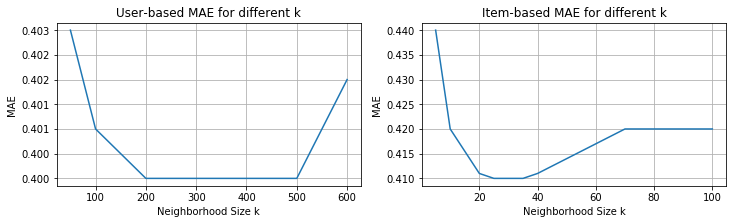

In [33]:
# Plot error
fig = plt.figure(figsize=(12,3))

ax1 = fig.add_subplot(121)
ax1.plot(user_k, mae_user)
ax1.set(xlabel='Neighborhood Size k', ylabel='MAE', title='User-based MAE for different k')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(item_k, mae_item)
ax2.set(xlabel='Neighborhood Size k', ylabel='MAE', title='Item-based MAE for different k')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.grid()

plt.show()

#### 4.3 Ranking Based Error

In [34]:
# Define function: combine train + test/pred
def combine_train_pred(train_mat, test_mat):
    rbo_train_rmat = train_mat
    rbo_test_rmat = test_mat
    
    rbo_train_rmat[np.isnan(rbo_train_rmat)] = 0
    rbo_test_rmat[np.isnan(rbo_test_rmat)] = 0
    
    rbo_true = rbo_train_rmat + rbo_test_rmat
    return rbo_true

In [35]:
# Define function: find the top t items for each user given a rating matrix
def top_t_item(rating_mat, t):
    # create a zero matrix to store the location of top t items
    ind_rmat = np.zeros_like(rating_mat)
    
    # find the location of top t items for each user
    col_ind = np.argsort(-rating_mat)[:,range(t)].flatten() #ind of top t items in each row
    row_ind = np.repeat(range(len(col_ind)), t).flatten() #corresponding row number
    
    for i in range(len(col_ind)):
        ind_rmat[row_ind[i], col_ind[i]] = 1
        
    return ind_rmat

In [36]:
# Define function: calculate the percentage of predicted top t in true top t items for each user
# return mean(percentage) of all users

def top_t_perc(true_ind_mat, pred_ind_mat, top_t_num):
    prod = true_ind_mat * pred_ind_mat
    rbo = np.mean(np.sum(prod, axis=1))/top_t_num
    return np.round(rbo, 4)

In [37]:
# train + test 
rbo_true = combine_train_pred(train_rmat, test_rmat) #rating matrix of all data, including train & test
rbo_true_ind = top_t_item(rbo_true, 10) #find top 5 of each row

In [38]:
# try top 10
topt = 15

In [39]:
# user_based

# if needed, use the following to store intermediate results
rbo_pred_user = {}  #dict to store whole rmat (train & pred) for each k
rbo_pred_user_ind = {}  # dict to store corresponding indicator matrix for each k

# get indicator matrix for each k, then calculate average percentage
rbo_perc_user = []

for k in user_k: 
    pred_rmat_rbo = pred_rmat_user_dict[str(k)]
    rbo_pred_user[str(k)] = combine_train_pred(train_rmat, pred_rmat_rbo) #combine pred & train 
    rbo_pred_user_ind[str(k)] = top_t_item(rbo_pred_user[str(k)], topt) #find top t  
    
    perc = top_t_perc(rbo_true_ind, rbo_pred_user_ind[str(k)], topt) #calculate percentage
    rbo_perc_user.append(perc)

In [40]:
# item_based

# if needed, use the following to store intermediate results
rbo_pred_item = {} #dict to store whole rmat (train & pred) for each k
rbo_pred_item_ind = {} # dict to store corresponding indicator matrix for each k

# get indicator matrix for each k, then calculate average percentage
rbo_perc_item = []

for k in item_k: 
    pred_rmat_rbo = pred_rmat_item_dict[str(k)]
    rbo_pred_item[str(k)] = combine_train_pred(train_rmat, pred_rmat_rbo) #combine pred & train
    rbo_pred_item_ind[str(k)] = top_t_item(rbo_pred_item[str(k)], topt) #find top t
    
    perc = top_t_perc(rbo_true_ind, rbo_pred_item_ind[str(k)], topt) #calculate percentage
    rbo_perc_item.append(perc)

#### Top 10 Prediction, Correct Ranking Rate (the higher the better)

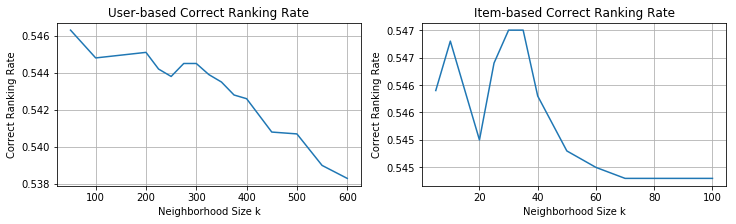

In [41]:
# Plot Ranking-Based Error
# Correct Ranking Rate = percentage of predicted top_t items in the true top_t items

fig = plt.figure(figsize=(12,3))

ax1 = fig.add_subplot(121)
ax1.plot(user_k, rbo_perc_user)
ax1.set(xlabel='Neighborhood Size k', ylabel='Correct Ranking Rate', 
        title='User-based Correct Ranking Rate')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(item_k, rbo_perc_item)
ax2.set(xlabel='Neighborhood Size k', ylabel='Correct Ranking Rate', 
        title='Item-based Correct Ranking Rate')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.grid()

plt.show()

#### Given neighborhood size K, compare Correct Ranking Rate for various recommendation size *T* 

user-based neighborhood size k = 300

item-based neighborhood size k = 40

In [42]:
t = [5,8,10,15,20,25,30,35,40,45,50,60]

In [43]:
# user_based
k = 300

rbo_perc_user2 = []
for topt in t:
    rbo_pred_user_ind[str(k)] = top_t_item(rbo_pred_user[str(k)], topt) #find top t  
    perc = top_t_perc(rbo_true_ind, rbo_pred_user_ind[str(k)], topt) #calculate percentage
    rbo_perc_user2.append(perc)

In [44]:
# item_based
k = 40

rbo_perc_item2 = []
for topt in t:
    rbo_pred_item_ind[str(k)] = top_t_item(rbo_pred_item[str(k)], topt) #find top t 
    perc = top_t_perc(rbo_true_ind, rbo_pred_item_ind[str(k)], topt) #calculate percentage
    rbo_perc_item2.append(perc)

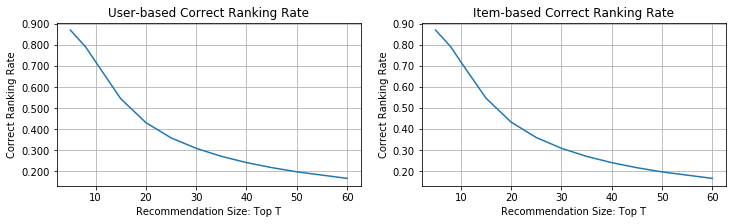

In [45]:
# Plot Ranking-Based Error
# Correct Ranking Rate = percentage of predicted top_t items in the true top_t items

fig = plt.figure(figsize=(12,3))

ax1 = fig.add_subplot(121)
ax1.plot(t, rbo_perc_user2)
ax1.set(xlabel='Recommendation Size: Top T', ylabel='Correct Ranking Rate', 
        title='User-based Correct Ranking Rate')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(t, rbo_perc_item2)
ax2.set(xlabel='Recommendation Size: Top T', ylabel='Correct Ranking Rate', 
        title='Item-based Correct Ranking Rate')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.grid()

plt.show()

### 5. Check Scalibility - Scale Up Sample Size
from 100 $*$ 1000 to 200 $*$ 2000

In [46]:
# Take m users & n items
m, n = 2000, 200

# Take top 2000/33382 most frequent users
user_freqtable = data2.review_profileName.value_counts()
user_list = user_freqtable.keys()[:m].tolist()

# Take top 200/56855 most reviewed beer
beer_freqtable = data2.beer_name.value_counts()[:200]
beer_list = beer_freqtable.keys()[:n].tolist()

# Final sample size
subdata = data2[data2.beer_name.isin(beer_list)]
subdata = subdata[subdata.review_profileName.isin(user_list)]
print('Take the top %d users and top %d items as sample data. The Sample size is %s.' % (m,n,str(subdata.shape))) 

# Split training & test set: should not have empty rows or columns
subdata2 = subdata[['beer_name','review_profileName','review_overall']]

train, test = train_test_split(subdata2, test_size=.2, random_state=1)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

Take the top 2000 users and top 200 items as sample data. The Sample size is (167115, 5).


In [47]:
# Create index dict; keys are user/beer names, values are corresponding row/col in rmat
#m = len(user_list)
#n = len(beer_list)
user_dict = {user_list[k]: k for k in range(m)}
beer_dict = {beer_list[k]: k for k in range(n)}

# Create train rating matrix: for both used- and item-based
train_rmat = Rmat(user_dict, beer_dict, train)

# Create test rating matrix: for both used- and item-based
test_rmat = Rmat(user_dict, beer_dict, test)

# Create prediction matrix - NaN
user = np.where(pd.notnull(test_rmat))[0] 
item = np.where(pd.notnull(test_rmat))[1] 

pred_rmat_user = np.full([m, n], np.nan)
pred_rmat_item = np.full([m, n], np.nan)

In [48]:
# check if there is empty row/column in training set
0 in np.sum(train_rmat, axis=0), 0 in np.sum(train_rmat, axis=1)

(False, False)

#### 5.1 user-based

In [49]:
# compute mean_adjusted rating of each user: subtract mean from ratings
adj_rmat_user = [train_rmat[0] - np.nanmean(train_rmat[0])]
for i in range(1,len(train_rmat)):
    adj_rmat_user = np.append(adj_rmat_user, [train_rmat[i] - np.nanmean(train_rmat[i])], axis=0)

In [50]:
# compute Pearson similiarity matrix 
sim_user = np.full([m, m], np.nan)

for u,v in it.combinations(range(len(user_list)), 2): 
    sim_user[u][v] = Pearson(adj_rmat_user[u], adj_rmat_user[v])
    sim_user[v][u] = sim_user[u][v]

/Users/yilinsun/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [51]:
# predict
k = 500
for ind in range(len(user)): 
    i, j = user[ind], item[ind]
    pred_rmat_user[i, j] = PredRating(sim_user, adj_rmat_user, i, j, k, 'user')
    
# calculate RMSE
user_rmse = RMSE(test_rmat, pred_rmat_user)
print('User-based collaborative filtering error is %.4f' % (user_rmse))

User-based collaborative filtering error is 0.5459


#### 5.2 item-based

In [52]:
# compute mean_adjusted rating vector of each item
adj_rmat_item = [train_rmat[:,0] - np.nanmean(train_rmat[:,0])]
for i in range(1,len(train_rmat[0])):
    adj_rmat_item = np.append(adj_rmat_item, [train_rmat[:,i] - np.nanmean(train_rmat[:,i])], axis=0)

adj_rmat_item = np.transpose(adj_rmat_item)

In [53]:
# compuete Pearson similiarity matrix 
sim_item = np.full([n, n], np.nan)
for u,v in it.combinations(range(len(beer_list)), 2): 
    sim_item[u][v] = Pearson(adj_rmat_item[u], adj_rmat_item[v])
    sim_item[v][u] = sim_item[u][v]

In [54]:
# predict 
k = 50
for ind in range(len(item)): 
    i, j = user[ind], item[ind]
    pred_rmat_item[i, j] = PredRating(sim_item, adj_rmat_item, i, j, k, 'item')
    
# calculate RMSE
item_rmse = RMSE(test_rmat, pred_rmat_item)
print('Item-based collaborative filtering error is %.4f' % (item_rmse))

Item-based collaborative filtering error is 0.5550
